# AlexNet

In [1]:
# Setup
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from pathlib import Path 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision import transforms
import torchmetrics
from torchsummary import summary

# imported from separate python files
from alexnet import AlexNet 

In [2]:
# Config
num_class = 10
batch_size = 128
seed = 43
num_epoch = 20

# Data


In [3]:
# Define transformation on data
# -> Convert image to tensor
# -> Normalizing data with the specified values of mean and standard deviation 
transform = transforms.Compose(
    [   transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        

    ]
)

# Downloading the data (CIFAR10) from torchvision datasets
data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Split the data into train and validation set
train_data, val_data = random_split(data, [0.9, 0.1])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Creating Dataloaders 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Class in CIFAR10 dataset
classes  = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

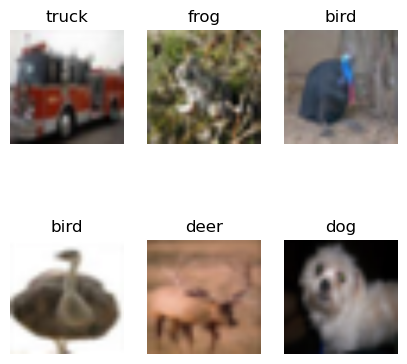

In [5]:
# Visualize an image
def imshow(img, label):
    # Unnormalize the image
    img = img * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1) + torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1) 
    npimg = img.numpy()
    

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label])
    plt.axis('off')
    


# batch of training data
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
plt.figure(figsize=(5, 5))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i], labels[i])

In [6]:
# GPU Setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.manual_seed(seed)

cuda:0


In [7]:
# Training and testing functions

# Training function
def training_step(model, data_loader, optimizer, criterion, train_acc):
    model.train()
    running_loss = 0.0
    train_acc.reset()

    for  data in tqdm(data_loader):
        # get inputs
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients 
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()
        optimizer.step()

        # metric
        running_loss = running_loss + loss.item()
        train_acc.update(outputs, labels)

    train_loss = running_loss / len(data_loader)
    train_accuracy = train_acc.compute().item()
    return train_loss, train_accuracy


# Validation function
def val_step(model, data_loader, criterion, val_acc):
    model.eval()
    val_loss = 0.0
    val_acc.reset()

    with torch.no_grad():
        for data in tqdm(data_loader):
            # get inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # metric
            val_loss = val_loss + loss.item()
            val_acc.update(outputs, labels)

    val_loss = val_loss / len(data_loader)
    val_accuracy = val_acc.compute().item()
    return val_loss, val_accuracy

def test_step(model, data_loader):
    model.eval()
    eval_loss = 0.0
    test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    test_acc.reset()

    all_label = []
    all_pred = []

    with torch.no_grad():
        for data in tqdm(data_loader):
            # get inputs
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(outputs, labels)

            # Convert logits to class predictions (using argmax)
            _, predicted = torch.max(outputs, 1)
            
            all_label.extend(labels.to('cpu').numpy())
            all_pred.extend(predicted.to('cpu').numpy())

            # metric
            eval_loss = eval_loss + loss.item()
            test_acc.update(outputs, labels)

    eval_loss = eval_loss / len(data_loader)
    test_accuracy = test_acc.compute().item()

    print(f'Test Accuracy: {test_accuracy:.2f}')
    print()

    # Classification Report
    print('Classification Report: ')
    print(classification_report(all_label, all_pred))

    

# Model Training 
def model_training(model, train_dataloader, val_dataloader, num_epoch, save_path, optimizer):

    # Setting up loss and optimizer
    criterion = nn.CrossEntropyLoss()

    # define metrics
    train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class).to(device)
    best_val_accuracy = 0.0


    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epoch):
        train_loss, train_accuracy = training_step(model, train_dataloader, optimizer, criterion, train_acc)
        val_loss, val_accuracy = val_step(model, val_dataloader, criterion, val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}')

        #  storing metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Save model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Model saved with Validation Accuracy: {best_val_accuracy:.2f}")

    
    # ploting train vs val loss and accuracy curve
    plt.figure(figsize=(12, 5))

    # ploting loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epoch + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epoch + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epoch + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epoch + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Model Training

In [8]:
model_alexnet = AlexNet(num_classes=num_class)
model_alexnet.to(device)
summary(model_alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
         MaxPool2d-2           [-1, 96, 27, 27]               0
            Conv2d-3          [-1, 256, 27, 27]         614,656
         MaxPool2d-4          [-1, 256, 13, 13]               0
            Conv2d-5          [-1, 384, 13, 13]         885,120
            Conv2d-6          [-1, 384, 13, 13]       1,327,488
            Conv2d-7          [-1, 256, 13, 13]         884,992
         MaxPool2d-8            [-1, 256, 6, 6]               0
            Linear-9                 [-1, 4096]      37,752,832
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 4096]      16,781,312
          Dropout-12                 [-1, 4096]               0
           Linear-13                   [-1, 10]          40,970
Total params: 58,322,314
Trainable para

100%|██████████| 40/40 [00:11<00:00,  3.41it/s]


Epoch 1, Train Loss: 2.3018, Train Accuracy: 0.12, Validation Loss: 2.3005, Validation Accuracy: 0.15
Model saved with Validation Accuracy: 0.15


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 2, Train Loss: 2.2949, Train Accuracy: 0.14, Validation Loss: 2.2725, Validation Accuracy: 0.13


100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Epoch 3, Train Loss: 2.1228, Train Accuracy: 0.22, Validation Loss: 1.9505, Validation Accuracy: 0.27
Model saved with Validation Accuracy: 0.27


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 4, Train Loss: 1.9022, Train Accuracy: 0.30, Validation Loss: 1.7950, Validation Accuracy: 0.33
Model saved with Validation Accuracy: 0.33


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Epoch 5, Train Loss: 1.7204, Train Accuracy: 0.37, Validation Loss: 1.5869, Validation Accuracy: 0.41
Model saved with Validation Accuracy: 0.41


100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


Epoch 6, Train Loss: 1.5976, Train Accuracy: 0.42, Validation Loss: 1.5100, Validation Accuracy: 0.45
Model saved with Validation Accuracy: 0.45


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 7, Train Loss: 1.5016, Train Accuracy: 0.45, Validation Loss: 1.4262, Validation Accuracy: 0.47
Model saved with Validation Accuracy: 0.47


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 8, Train Loss: 1.4238, Train Accuracy: 0.49, Validation Loss: 1.3695, Validation Accuracy: 0.50
Model saved with Validation Accuracy: 0.50


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch 9, Train Loss: 1.3534, Train Accuracy: 0.51, Validation Loss: 1.3090, Validation Accuracy: 0.53
Model saved with Validation Accuracy: 0.53


100%|██████████| 40/40 [00:11<00:00,  3.35it/s]


Epoch 10, Train Loss: 1.2869, Train Accuracy: 0.54, Validation Loss: 1.2209, Validation Accuracy: 0.56
Model saved with Validation Accuracy: 0.56


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch 11, Train Loss: 1.2243, Train Accuracy: 0.56, Validation Loss: 1.1253, Validation Accuracy: 0.59
Model saved with Validation Accuracy: 0.59


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 12, Train Loss: 1.1625, Train Accuracy: 0.59, Validation Loss: 1.1000, Validation Accuracy: 0.61
Model saved with Validation Accuracy: 0.61


100%|██████████| 40/40 [00:11<00:00,  3.35it/s]


Epoch 13, Train Loss: 1.1061, Train Accuracy: 0.61, Validation Loss: 1.0596, Validation Accuracy: 0.63
Model saved with Validation Accuracy: 0.63


100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Epoch 14, Train Loss: 1.0473, Train Accuracy: 0.63, Validation Loss: 0.9817, Validation Accuracy: 0.65
Model saved with Validation Accuracy: 0.65


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 15, Train Loss: 0.9929, Train Accuracy: 0.65, Validation Loss: 0.9323, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


Epoch 16, Train Loss: 0.9397, Train Accuracy: 0.67, Validation Loss: 0.9075, Validation Accuracy: 0.68
Model saved with Validation Accuracy: 0.68


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 17, Train Loss: 0.9008, Train Accuracy: 0.69, Validation Loss: 0.9651, Validation Accuracy: 0.67


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch 18, Train Loss: 0.8629, Train Accuracy: 0.70, Validation Loss: 0.8548, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:11<00:00,  3.39it/s]


Epoch 19, Train Loss: 0.8109, Train Accuracy: 0.72, Validation Loss: 0.8544, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Epoch 20, Train Loss: 0.7642, Train Accuracy: 0.73, Validation Loss: 0.8137, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


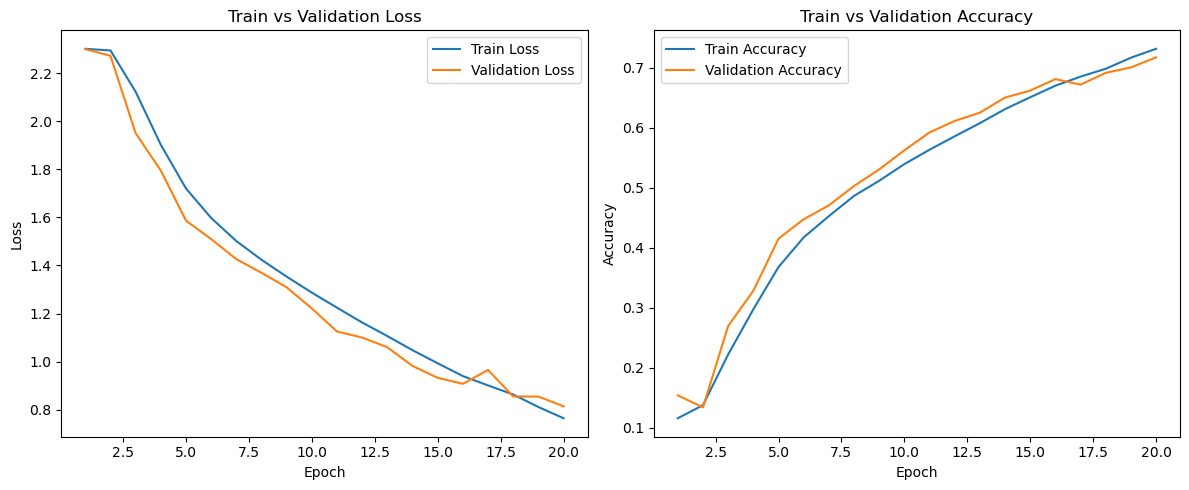

In [8]:
# initial setup
model_alexnet = AlexNet(num_classes=num_class)
model_alexnet.to(device)
optimizer = optim.SGD(model_alexnet.parameters(), lr=0.001, momentum=0.9)

alexnet_weight_save_path = Path('./save_model/best_model_AlexNet_SGD_lr_0.001.pth')

model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

In [9]:
best_model = AlexNet(num_classes=num_class)
best_model.load_state_dict(torch.load(alexnet_weight_save_path))
best_model.to(device)

test_step(best_model, test_dataloader)
torch.cuda.empty_cache()
time.sleep(30)

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\3574835265.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(alexnet_weight_save_pa

Test Accuracy: 0.72

Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1000
           1       0.79      0.90      0.84      1000
           2       0.66      0.58      0.62      1000
           3       0.59      0.41      0.49      1000
           4       0.70      0.61      0.65      1000
           5       0.55      0.74      0.63      1000
           6       0.76      0.82      0.79      1000
           7       0.77      0.78      0.77      1000
           8       0.78      0.88      0.83      1000
           9       0.85      0.75      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



### Experiment with AlexNet

Learning Rate:  0.0001
Model Training


100%|██████████| 40/40 [00:11<00:00,  3.47it/s]


Epoch 1, Train Loss: 2.3026, Train Accuracy: 0.10, Validation Loss: 2.3024, Validation Accuracy: 0.12
Model saved with Validation Accuracy: 0.12


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 2, Train Loss: 2.3024, Train Accuracy: 0.10, Validation Loss: 2.3023, Validation Accuracy: 0.12


100%|██████████| 40/40 [00:11<00:00,  3.41it/s]


Epoch 3, Train Loss: 2.3022, Train Accuracy: 0.11, Validation Loss: 2.3021, Validation Accuracy: 0.12


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 4, Train Loss: 2.3020, Train Accuracy: 0.11, Validation Loss: 2.3018, Validation Accuracy: 0.11


100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


Epoch 5, Train Loss: 2.3017, Train Accuracy: 0.11, Validation Loss: 2.3014, Validation Accuracy: 0.13
Model saved with Validation Accuracy: 0.13


100%|██████████| 40/40 [00:12<00:00,  3.30it/s]


Epoch 6, Train Loss: 2.3015, Train Accuracy: 0.12, Validation Loss: 2.3012, Validation Accuracy: 0.14
Model saved with Validation Accuracy: 0.14


100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


Epoch 7, Train Loss: 2.3011, Train Accuracy: 0.12, Validation Loss: 2.3007, Validation Accuracy: 0.15
Model saved with Validation Accuracy: 0.15


100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


Epoch 8, Train Loss: 2.3007, Train Accuracy: 0.13, Validation Loss: 2.3003, Validation Accuracy: 0.15


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch 9, Train Loss: 2.3003, Train Accuracy: 0.13, Validation Loss: 2.2998, Validation Accuracy: 0.14


100%|██████████| 40/40 [00:11<00:00,  3.45it/s]


Epoch 10, Train Loss: 2.2996, Train Accuracy: 0.14, Validation Loss: 2.2988, Validation Accuracy: 0.15


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 11, Train Loss: 2.2990, Train Accuracy: 0.14, Validation Loss: 2.2981, Validation Accuracy: 0.17
Model saved with Validation Accuracy: 0.17


100%|██████████| 40/40 [00:11<00:00,  3.38it/s]


Epoch 12, Train Loss: 2.2979, Train Accuracy: 0.14, Validation Loss: 2.2964, Validation Accuracy: 0.18
Model saved with Validation Accuracy: 0.18


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 13, Train Loss: 2.2963, Train Accuracy: 0.14, Validation Loss: 2.2941, Validation Accuracy: 0.18
Model saved with Validation Accuracy: 0.18


100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


Epoch 14, Train Loss: 2.2935, Train Accuracy: 0.14, Validation Loss: 2.2906, Validation Accuracy: 0.16


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 15, Train Loss: 2.2887, Train Accuracy: 0.14, Validation Loss: 2.2839, Validation Accuracy: 0.13


100%|██████████| 40/40 [00:11<00:00,  3.46it/s]


Epoch 16, Train Loss: 2.2798, Train Accuracy: 0.13, Validation Loss: 2.2710, Validation Accuracy: 0.12


100%|██████████| 40/40 [00:11<00:00,  3.39it/s]


Epoch 17, Train Loss: 2.2651, Train Accuracy: 0.13, Validation Loss: 2.2537, Validation Accuracy: 0.13


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 18, Train Loss: 2.2474, Train Accuracy: 0.15, Validation Loss: 2.2313, Validation Accuracy: 0.17


100%|██████████| 40/40 [00:11<00:00,  3.40it/s]


Epoch 19, Train Loss: 2.2228, Train Accuracy: 0.18, Validation Loss: 2.1965, Validation Accuracy: 0.20
Model saved with Validation Accuracy: 0.20


100%|██████████| 40/40 [00:12<00:00,  3.26it/s]


Epoch 20, Train Loss: 2.1887, Train Accuracy: 0.21, Validation Loss: 2.1584, Validation Accuracy: 0.23
Model saved with Validation Accuracy: 0.23


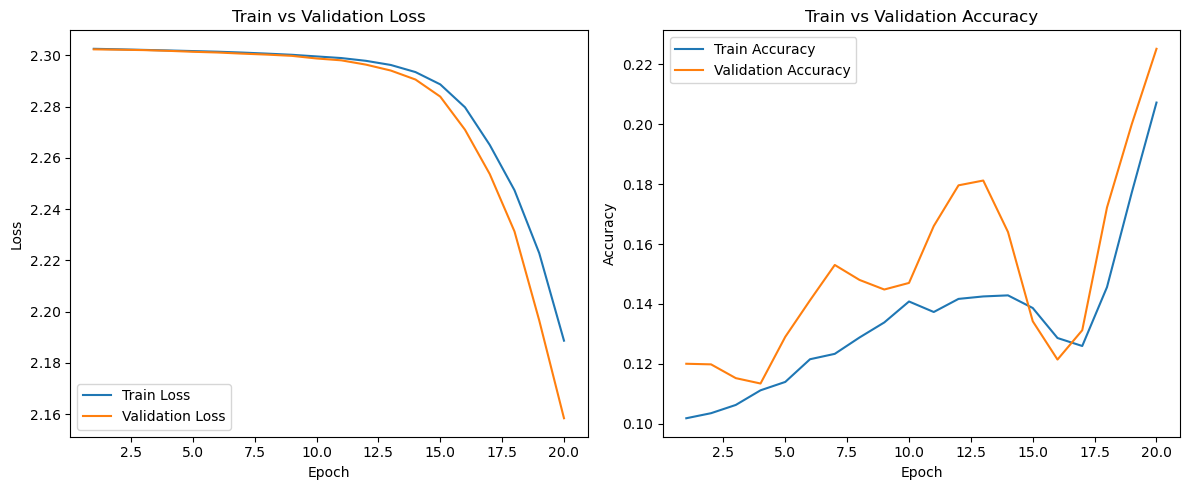

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\514796676.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:23<00:00,  3.31it/s]
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Test Accuracy: 0.23

Classification Report: 
              precision    recall  f1-score   support

           0       0.22      0.55      0.32      1000
           1       0.24      0.06      0.09      1000
           2       0.00      0.00      0.00      1000
           3       0.19      0.07      0.10      1000
           4       0.00      0.00      0.00      1000
           5       0.18      0.35      0.24      1000
           6       0.31      0.35      0.33      1000
           7       0.15      0.04      0.06      1000
           8       0.24      0.32      0.28      1000
           9       0.24      0.55      0.33      1000

    accuracy                           0.23     10000
   macro avg       0.18      0.23      0.17     10000
weighted avg       0.18      0.23      0.17     10000


Learning Rate:  0.01
Model Training


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


Epoch 1, Train Loss: 1.9627, Train Accuracy: 0.26, Validation Loss: 1.5103, Validation Accuracy: 0.44
Model saved with Validation Accuracy: 0.44


100%|██████████| 40/40 [00:11<00:00,  3.36it/s]


Epoch 2, Train Loss: 1.4222, Train Accuracy: 0.48, Validation Loss: 1.1738, Validation Accuracy: 0.58
Model saved with Validation Accuracy: 0.58


100%|██████████| 40/40 [00:12<00:00,  3.29it/s]


Epoch 3, Train Loss: 1.1067, Train Accuracy: 0.61, Validation Loss: 0.9901, Validation Accuracy: 0.65
Model saved with Validation Accuracy: 0.65


100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


Epoch 4, Train Loss: 0.8757, Train Accuracy: 0.69, Validation Loss: 0.7954, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


Epoch 5, Train Loss: 0.7139, Train Accuracy: 0.75, Validation Loss: 0.7065, Validation Accuracy: 0.75
Model saved with Validation Accuracy: 0.75


100%|██████████| 40/40 [00:11<00:00,  3.36it/s]


Epoch 6, Train Loss: 0.6036, Train Accuracy: 0.79, Validation Loss: 0.6590, Validation Accuracy: 0.78
Model saved with Validation Accuracy: 0.78


100%|██████████| 40/40 [00:11<00:00,  3.35it/s]


Epoch 7, Train Loss: 0.4892, Train Accuracy: 0.83, Validation Loss: 0.6224, Validation Accuracy: 0.79
Model saved with Validation Accuracy: 0.79


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 8, Train Loss: 0.4115, Train Accuracy: 0.86, Validation Loss: 0.6070, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:11<00:00,  3.35it/s]


Epoch 9, Train Loss: 0.3262, Train Accuracy: 0.89, Validation Loss: 0.5683, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:11<00:00,  3.34it/s]


Epoch 10, Train Loss: 0.2523, Train Accuracy: 0.91, Validation Loss: 0.6004, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Epoch 11, Train Loss: 0.2113, Train Accuracy: 0.93, Validation Loss: 0.6876, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


Epoch 12, Train Loss: 0.1621, Train Accuracy: 0.94, Validation Loss: 0.6805, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:11<00:00,  3.37it/s]


Epoch 13, Train Loss: 0.1438, Train Accuracy: 0.95, Validation Loss: 0.7772, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:11<00:00,  3.38it/s]


Epoch 14, Train Loss: 0.1249, Train Accuracy: 0.96, Validation Loss: 0.7444, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Epoch 15, Train Loss: 0.1081, Train Accuracy: 0.96, Validation Loss: 0.8221, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:10<00:00,  3.96it/s]


Epoch 16, Train Loss: 0.0946, Train Accuracy: 0.97, Validation Loss: 0.8693, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:11<00:00,  3.50it/s]


Epoch 17, Train Loss: 0.0765, Train Accuracy: 0.97, Validation Loss: 0.9382, Validation Accuracy: 0.79


100%|██████████| 40/40 [00:11<00:00,  3.54it/s]


Epoch 18, Train Loss: 0.0766, Train Accuracy: 0.97, Validation Loss: 0.8637, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:11<00:00,  3.51it/s]


Epoch 19, Train Loss: 0.0745, Train Accuracy: 0.98, Validation Loss: 0.8792, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:11<00:00,  3.45it/s]


Epoch 20, Train Loss: 0.0700, Train Accuracy: 0.98, Validation Loss: 0.8426, Validation Accuracy: 0.82


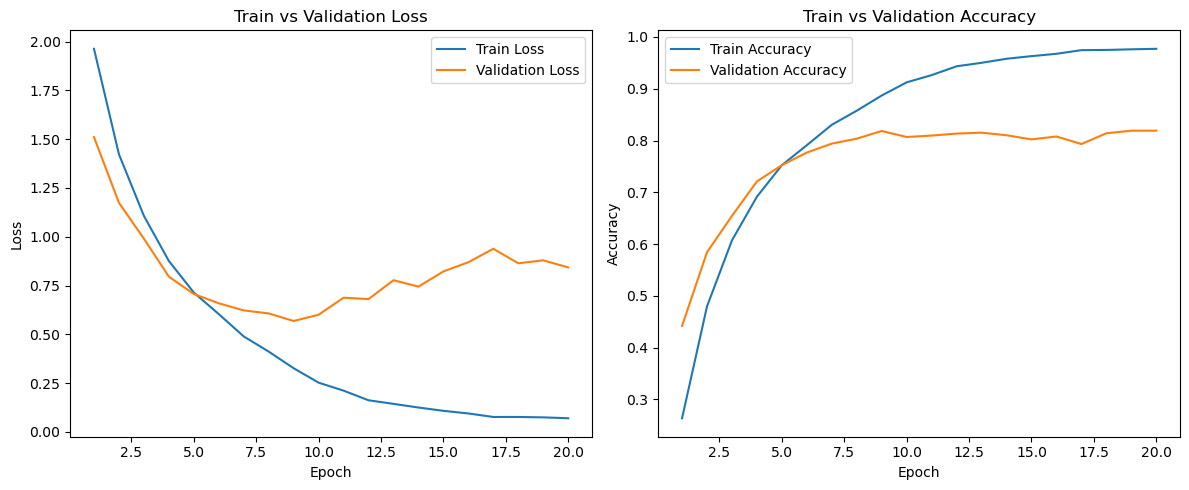

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\514796676.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:23<00:00,  3.42it/s]


Test Accuracy: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.89      0.92      0.91      1000
           2       0.70      0.79      0.74      1000
           3       0.69      0.63      0.66      1000
           4       0.85      0.76      0.80      1000
           5       0.78      0.71      0.75      1000
           6       0.86      0.87      0.86      1000
           7       0.84      0.87      0.85      1000
           8       0.86      0.88      0.87      1000
           9       0.89      0.86      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000




In [10]:
# Learning Rate Variation

learning_rates = [0.0001, 0.01]

for learning_rate in learning_rates:
    model_alexnet = AlexNet(num_classes=num_class)
    model_alexnet.to(device)

    print(f'Learning Rate:  {learning_rate}')
    
    optimizer = optim.SGD(model_alexnet.parameters(), lr=learning_rate, momentum=0.9)
    alexnet_weight_save_path = Path(f'./save_model/best_model_AlexNet_SGD_lr_{learning_rate}.pth')

    # Training model
    print("Model Training")
    model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

    # Load the best saved model weights for evaluation
    model_alexnet.load_state_dict(torch.load(alexnet_weight_save_path))
    
    # Evaluate model on test data
    print("Testing on the testset")
    test_step(model_alexnet, test_dataloader)
    
    torch.cuda.empty_cache()
    print()
    print("==============================================================================================================")
    time.sleep(30)

Weight Decay: 0.0001
Model Training


100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Epoch 1, Train Loss: 65744.0626, Train Accuracy: 0.10, Validation Loss: 2.3036, Validation Accuracy: 0.09
Model saved with Validation Accuracy: 0.09


100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Epoch 2, Train Loss: 15.0857, Train Accuracy: 0.10, Validation Loss: 2.3042, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Epoch 3, Train Loss: 28.3287, Train Accuracy: 0.10, Validation Loss: 2.3031, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 4, Train Loss: 4.5832, Train Accuracy: 0.10, Validation Loss: 2.3044, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Epoch 5, Train Loss: 2.3264, Train Accuracy: 0.10, Validation Loss: 2.3030, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 6, Train Loss: 19.4755, Train Accuracy: 0.10, Validation Loss: 2.3046, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


Epoch 7, Train Loss: 4.4597, Train Accuracy: 0.10, Validation Loss: 2.3041, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 8, Train Loss: 2.3082, Train Accuracy: 0.10, Validation Loss: 2.3037, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 9, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3035, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.28it/s]


Epoch 10, Train Loss: 2.3035, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Epoch 11, Train Loss: 4.9560, Train Accuracy: 0.10, Validation Loss: 2.3047, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 12, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.11
Model saved with Validation Accuracy: 0.11


100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch 13, Train Loss: 88.9439, Train Accuracy: 0.10, Validation Loss: 2.3031, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 14, Train Loss: 2.3839, Train Accuracy: 0.10, Validation Loss: 2.3268, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Epoch 15, Train Loss: 2.3093, Train Accuracy: 0.10, Validation Loss: 2.3033, Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 16, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3034, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


Epoch 17, Train Loss: 2.3038, Train Accuracy: 0.10, Validation Loss: 2.3030, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 18, Train Loss: 2.3136, Train Accuracy: 0.10, Validation Loss: 2.3033, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Epoch 19, Train Loss: 2.3043, Train Accuracy: 0.10, Validation Loss: 2.3029, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


Epoch 20, Train Loss: 406.8297, Train Accuracy: 0.10, Validation Loss: 2.3073, Validation Accuracy: 0.10


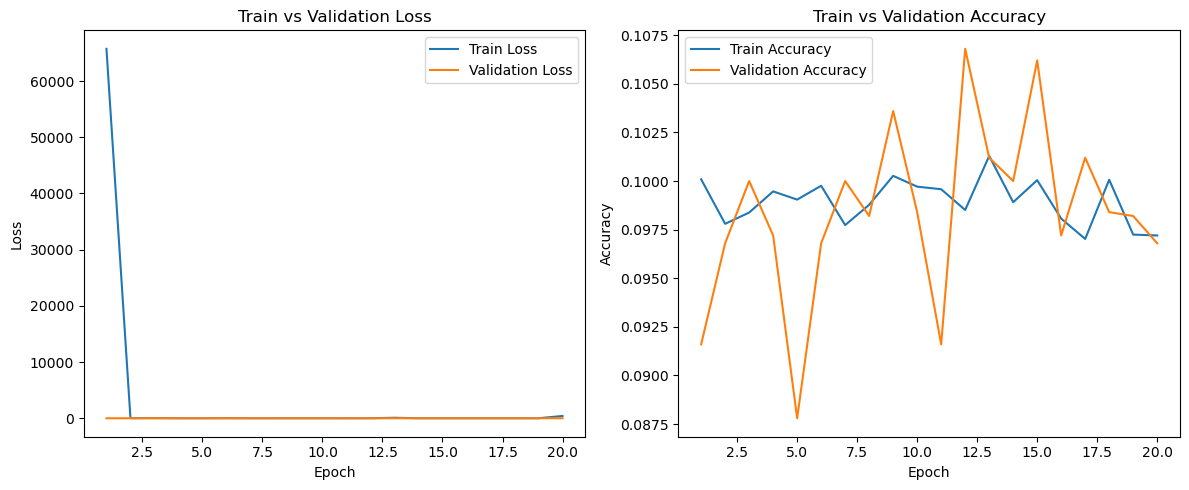

C:\Users\abrar\AppData\Local\Temp\ipykernel_33628\261670810.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:10<00:00,  7.75it/s]
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Test Accuracy: 0.10

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.10      1.00      0.18      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000


Weight Decay: 0.001
Model Training


100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Epoch 1, Train Loss: 6918.7834, Train Accuracy: 0.10, Validation Loss: 2.3036, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.10it/s]


Epoch 2, Train Loss: 2.3077, Train Accuracy: 0.10, Validation Loss: 2.3051, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.15it/s]


Epoch 3, Train Loss: 196.0378, Train Accuracy: 0.10, Validation Loss: 2.3102, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 4, Train Loss: 2576.8228, Train Accuracy: 0.10, Validation Loss: 3.2914, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.37it/s]


Epoch 5, Train Loss: 480482.3018, Train Accuracy: 0.10, Validation Loss: 2.3037, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 6, Train Loss: 15.8267, Train Accuracy: 0.10, Validation Loss: 2.3042, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 7, Train Loss: 3.3266, Train Accuracy: 0.10, Validation Loss: 2.3042, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Epoch 8, Train Loss: 2.5930, Train Accuracy: 0.10, Validation Loss: 2.3034, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:04<00:00,  8.38it/s]


Epoch 9, Train Loss: 59.6849, Train Accuracy: 0.10, Validation Loss: 2.3036, Validation Accuracy: 0.11
Model saved with Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.26it/s]


Epoch 10, Train Loss: 3.6927, Train Accuracy: 0.10, Validation Loss: 2.3031, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.41it/s]


Epoch 11, Train Loss: 2.3630, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 12, Train Loss: 389.0188, Train Accuracy: 0.10, Validation Loss: 2.3029, Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.04it/s]


Epoch 13, Train Loss: 3.0144, Train Accuracy: 0.10, Validation Loss: 2.3035, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 14, Train Loss: 2.3095, Train Accuracy: 0.10, Validation Loss: 2.3028, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


Epoch 15, Train Loss: 34781.5707, Train Accuracy: 0.10, Validation Loss: 2.3041, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.14it/s]


Epoch 16, Train Loss: 10.7711, Train Accuracy: 0.10, Validation Loss: 2.3055, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.18it/s]


Epoch 17, Train Loss: 93.4021, Train Accuracy: 0.10, Validation Loss: 2.3022, Validation Accuracy: 0.11
Model saved with Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Epoch 18, Train Loss: 2.3228, Train Accuracy: 0.10, Validation Loss: 2.3024, Validation Accuracy: 0.11


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 19, Train Loss: 2.3174, Train Accuracy: 0.10, Validation Loss: 2.3031, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Epoch 20, Train Loss: 3.0267, Train Accuracy: 0.10, Validation Loss: 2.3056, Validation Accuracy: 0.10


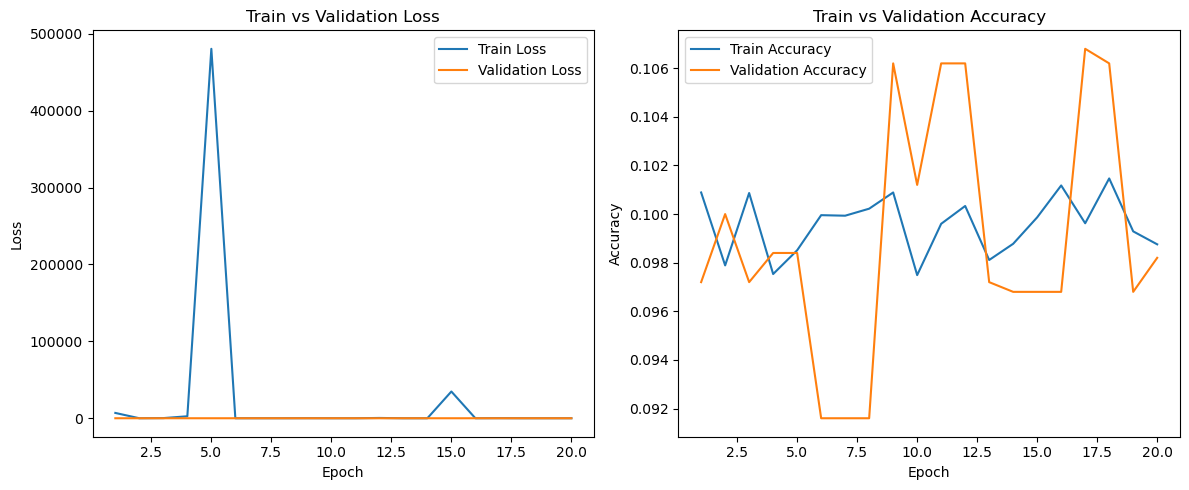

C:\Users\abrar\AppData\Local\Temp\ipykernel_33628\261670810.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:10<00:00,  7.61it/s]
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\abrar\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Test Accuracy: 0.10

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.00      0.00      0.00      1000
           8       0.10      1.00      0.18      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000




In [9]:
# Applying Regularization L2 (weight decay)

learning_rate = 0.01
weight_decay = [1e-4, 1e-3]

for wd in weight_decay:
    model_alexnet = AlexNet(num_classes=num_class)
    model_alexnet.to(device)

    print(f'Weight Decay: {wd}')
    
    optimizer = optim.Adam(model_alexnet.parameters(), lr=learning_rate, weight_decay=wd)
    alexnet_weight_save_path = Path(f'./save_model/best_model_alexnet_Adam_lr_{learning_rate}_wd_{wd}.pth')

    # Training model
    print("Model Training")
    model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

    # Load the best saved model weights for evaluation
    print("Testing on the testset")
    model_alexnet.load_state_dict(torch.load(alexnet_weight_save_path))
    
    # Evaluate model on test data
    test_step(model_alexnet, test_dataloader)
    
    torch.cuda.empty_cache()
    print()
    print("==============================================================================================================")
    time.sleep(30)

Learning Rate:  0.0001
Model Training


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch 1, Train Loss: 1.6346, Train Accuracy: 0.39, Validation Loss: 1.2598, Validation Accuracy: 0.54
Model saved with Validation Accuracy: 0.54


100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


Epoch 2, Train Loss: 1.1365, Train Accuracy: 0.59, Validation Loss: 0.9768, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Epoch 3, Train Loss: 0.8693, Train Accuracy: 0.69, Validation Loss: 0.8159, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Epoch 4, Train Loss: 0.7081, Train Accuracy: 0.75, Validation Loss: 0.6903, Validation Accuracy: 0.75
Model saved with Validation Accuracy: 0.75


100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Epoch 5, Train Loss: 0.5860, Train Accuracy: 0.80, Validation Loss: 0.6153, Validation Accuracy: 0.78
Model saved with Validation Accuracy: 0.78


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Epoch 6, Train Loss: 0.4942, Train Accuracy: 0.83, Validation Loss: 0.5731, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 7, Train Loss: 0.4015, Train Accuracy: 0.86, Validation Loss: 0.6059, Validation Accuracy: 0.79


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 8, Train Loss: 0.3151, Train Accuracy: 0.89, Validation Loss: 0.5838, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 9, Train Loss: 0.2400, Train Accuracy: 0.92, Validation Loss: 0.6260, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Epoch 10, Train Loss: 0.1810, Train Accuracy: 0.94, Validation Loss: 0.6994, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 11, Train Loss: 0.1389, Train Accuracy: 0.95, Validation Loss: 0.7119, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Epoch 12, Train Loss: 0.1033, Train Accuracy: 0.97, Validation Loss: 0.7217, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 13, Train Loss: 0.0907, Train Accuracy: 0.97, Validation Loss: 0.7345, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 14, Train Loss: 0.0777, Train Accuracy: 0.97, Validation Loss: 0.7445, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:14<00:00,  2.76it/s]


Epoch 15, Train Loss: 0.0643, Train Accuracy: 0.98, Validation Loss: 0.8078, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Epoch 16, Train Loss: 0.0671, Train Accuracy: 0.98, Validation Loss: 0.8117, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


Epoch 17, Train Loss: 0.0563, Train Accuracy: 0.98, Validation Loss: 0.9016, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Epoch 18, Train Loss: 0.0471, Train Accuracy: 0.98, Validation Loss: 0.9322, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Epoch 19, Train Loss: 0.0527, Train Accuracy: 0.98, Validation Loss: 0.9480, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 20, Train Loss: 0.0470, Train Accuracy: 0.98, Validation Loss: 1.0226, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


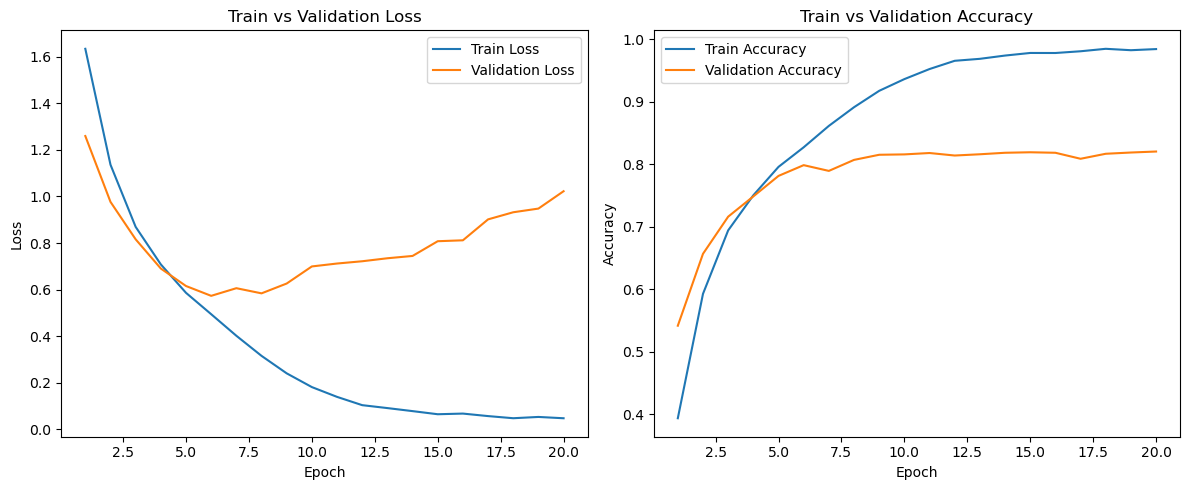

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\521963445.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:24<00:00,  3.17it/s]


Test Accuracy: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1000
           1       0.91      0.90      0.90      1000
           2       0.79      0.73      0.76      1000
           3       0.68      0.66      0.67      1000
           4       0.71      0.87      0.78      1000
           5       0.85      0.64      0.73      1000
           6       0.81      0.91      0.85      1000
           7       0.84      0.86      0.85      1000
           8       0.90      0.89      0.89      1000
           9       0.91      0.83      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000


Learning Rate:  0.001
Model Training


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 1, Train Loss: 1.7557, Train Accuracy: 0.35, Validation Loss: 1.4119, Validation Accuracy: 0.48
Model saved with Validation Accuracy: 0.48


100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 2, Train Loss: 1.3675, Train Accuracy: 0.51, Validation Loss: 1.2008, Validation Accuracy: 0.57
Model saved with Validation Accuracy: 0.57


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 3, Train Loss: 1.1943, Train Accuracy: 0.57, Validation Loss: 1.1052, Validation Accuracy: 0.61
Model saved with Validation Accuracy: 0.61


100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Epoch 4, Train Loss: 1.0799, Train Accuracy: 0.62, Validation Loss: 1.0283, Validation Accuracy: 0.63
Model saved with Validation Accuracy: 0.63


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Epoch 5, Train Loss: 0.9972, Train Accuracy: 0.65, Validation Loss: 0.9787, Validation Accuracy: 0.65
Model saved with Validation Accuracy: 0.65


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 6, Train Loss: 0.9202, Train Accuracy: 0.68, Validation Loss: 1.0289, Validation Accuracy: 0.64


100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Epoch 7, Train Loss: 0.8502, Train Accuracy: 0.70, Validation Loss: 1.0143, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 8, Train Loss: 0.7884, Train Accuracy: 0.72, Validation Loss: 0.9348, Validation Accuracy: 0.67
Model saved with Validation Accuracy: 0.67


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 9, Train Loss: 0.7425, Train Accuracy: 0.74, Validation Loss: 1.0038, Validation Accuracy: 0.67
Model saved with Validation Accuracy: 0.67


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 10, Train Loss: 0.6754, Train Accuracy: 0.76, Validation Loss: 0.9315, Validation Accuracy: 0.68
Model saved with Validation Accuracy: 0.68


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 11, Train Loss: 0.6312, Train Accuracy: 0.78, Validation Loss: 0.9396, Validation Accuracy: 0.68


100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Epoch 12, Train Loss: 0.5889, Train Accuracy: 0.79, Validation Loss: 1.0063, Validation Accuracy: 0.67


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 13, Train Loss: 0.5286, Train Accuracy: 0.81, Validation Loss: 1.0175, Validation Accuracy: 0.67


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 14, Train Loss: 0.5093, Train Accuracy: 0.83, Validation Loss: 0.9995, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Epoch 15, Train Loss: 0.4580, Train Accuracy: 0.84, Validation Loss: 1.0648, Validation Accuracy: 0.68


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 16, Train Loss: 0.4247, Train Accuracy: 0.85, Validation Loss: 1.0029, Validation Accuracy: 0.69


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 17, Train Loss: 0.3985, Train Accuracy: 0.86, Validation Loss: 1.0463, Validation Accuracy: 0.69


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


Epoch 18, Train Loss: 0.3896, Train Accuracy: 0.87, Validation Loss: 1.0579, Validation Accuracy: 0.68


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 19, Train Loss: 0.3631, Train Accuracy: 0.88, Validation Loss: 1.0693, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


Epoch 20, Train Loss: 0.3546, Train Accuracy: 0.88, Validation Loss: 1.0695, Validation Accuracy: 0.67


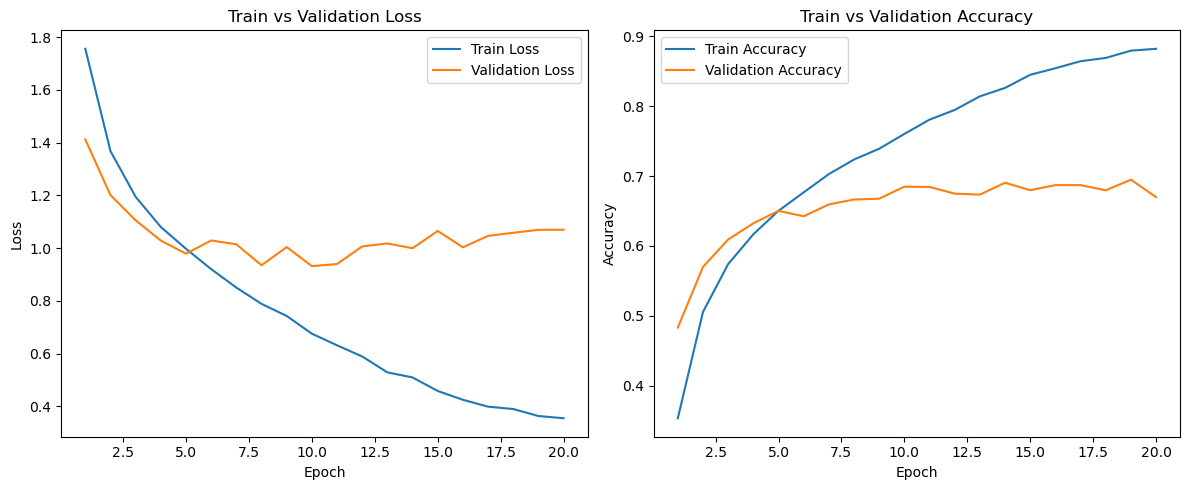

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\521963445.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Test Accuracy: 0.68

Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      1000
           1       0.87      0.80      0.83      1000
           2       0.62      0.51      0.56      1000
           3       0.48      0.49      0.49      1000
           4       0.59      0.65      0.62      1000
           5       0.57      0.56      0.56      1000
           6       0.73      0.79      0.76      1000
           7       0.71      0.72      0.71      1000
           8       0.77      0.78      0.78      1000
           9       0.80      0.76      0.78      1000

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.68     10000
weighted avg       0.68      0.68      0.68     10000


Learning Rate:  0.01
Model Training


100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Epoch 1, Train Loss: 26674.3677, Train Accuracy: 0.10, Validation Loss: 2.3031, Validation Accuracy: 0.09
Model saved with Validation Accuracy: 0.09


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Epoch 2, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 3, Train Loss: 2.3032, Train Accuracy: 0.10, Validation Loss: 2.3027, Validation Accuracy: 0.10
Model saved with Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 4, Train Loss: 2.3031, Train Accuracy: 0.10, Validation Loss: 2.3042, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 5, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3028, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Epoch 6, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3029, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 7, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3029, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


Epoch 8, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 9, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3030, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 10, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3029, Validation Accuracy: 0.11
Model saved with Validation Accuracy: 0.11


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 11, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3026, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  2.97it/s]


Epoch 12, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3030, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 13, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3023, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


Epoch 14, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3030, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 15, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3039, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 16, Train Loss: 2.3034, Train Accuracy: 0.10, Validation Loss: 2.3032, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


Epoch 17, Train Loss: 2.3032, Train Accuracy: 0.10, Validation Loss: 2.3039, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Epoch 18, Train Loss: 2.3033, Train Accuracy: 0.10, Validation Loss: 2.3035, Validation Accuracy: 0.10


100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Epoch 19, Train Loss: 2.3032, Train Accuracy: 0.10, Validation Loss: 2.3042, Validation Accuracy: 0.09


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 20, Train Loss: 2.3035, Train Accuracy: 0.10, Validation Loss: 2.3020, Validation Accuracy: 0.11


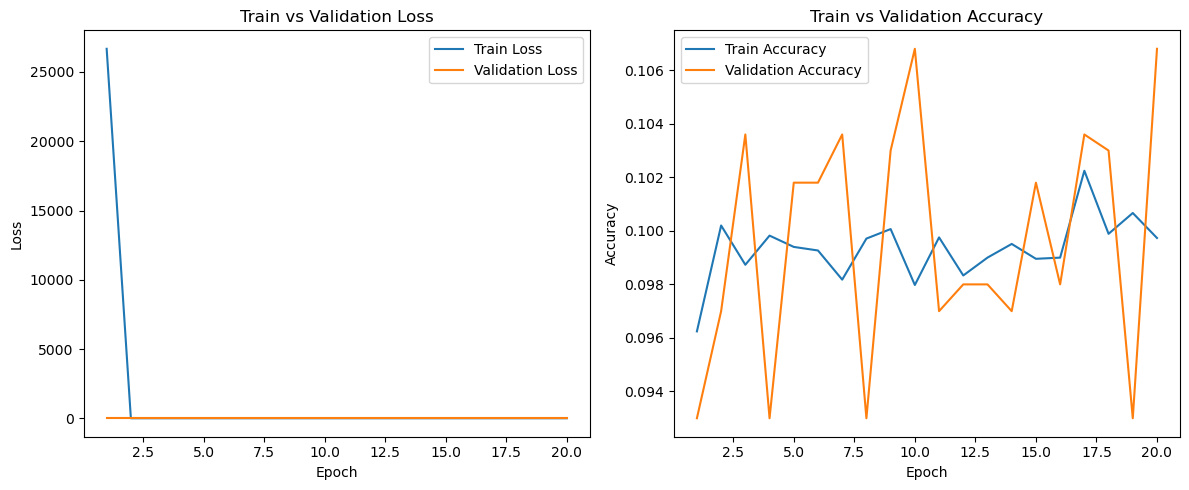

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\521963445.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_save

Testing on the testset


100%|██████████| 79/79 [00:25<00:00,  3.07it/s]
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\abrar\anaconda3\envs\labo\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Test Accuracy: 0.10

Classification Report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.00      0.00      0.00      1000
           2       0.00      0.00      0.00      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.10      1.00      0.18      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000




In [12]:
# Trying a different optimizer Adam with different learning rate
# Learning Rate Variation

learning_rates = [0.0001, 0.001, 0.01]

for learning_rate in learning_rates:
    model_alexnet = AlexNet(num_classes=num_class)
    model_alexnet.to(device)

    print(f'Learning Rate:  {learning_rate}')

    optimizer = optim.Adam(model_alexnet.parameters(), lr=learning_rate)
    alexnet_weight_save_path = Path(f'./save_model/best_model_AlexNet_Adam_lr_{learning_rate}.pth')

    # Training model
    print("Model Training")
    model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

    # Load the best saved model weights for evaluation
    model_alexnet.load_state_dict(torch.load(alexnet_weight_save_path))
    
    # Evaluate model on test data
    print("Testing on the testset")
    test_step(model_alexnet, test_dataloader)

    torch.cuda.empty_cache()
    time.sleep(15)
    print()
    print("==============================================================================================================")
    time.sleep(30)

Weight Decay: 0.0001
Model Training


100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Epoch 1, Train Loss: 1.7887, Train Accuracy: 0.34, Validation Loss: 1.4179, Validation Accuracy: 0.49
Model saved with Validation Accuracy: 0.49


100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


Epoch 2, Train Loss: 1.3209, Train Accuracy: 0.52, Validation Loss: 1.2077, Validation Accuracy: 0.56
Model saved with Validation Accuracy: 0.56


100%|██████████| 40/40 [00:16<00:00,  2.47it/s]


Epoch 3, Train Loss: 1.1518, Train Accuracy: 0.59, Validation Loss: 1.0945, Validation Accuracy: 0.61
Model saved with Validation Accuracy: 0.61


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Epoch 4, Train Loss: 1.0307, Train Accuracy: 0.64, Validation Loss: 0.9650, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Epoch 5, Train Loss: 0.9534, Train Accuracy: 0.67, Validation Loss: 0.9790, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:16<00:00,  2.43it/s]


Epoch 6, Train Loss: 0.8788, Train Accuracy: 0.70, Validation Loss: 0.9004, Validation Accuracy: 0.68
Model saved with Validation Accuracy: 0.68


100%|██████████| 40/40 [00:16<00:00,  2.36it/s]


Epoch 7, Train Loss: 0.8149, Train Accuracy: 0.71, Validation Loss: 0.8535, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:15<00:00,  2.52it/s]


Epoch 8, Train Loss: 0.7595, Train Accuracy: 0.74, Validation Loss: 0.8747, Validation Accuracy: 0.69


100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


Epoch 9, Train Loss: 0.7118, Train Accuracy: 0.75, Validation Loss: 0.8593, Validation Accuracy: 0.71
Model saved with Validation Accuracy: 0.71


100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


Epoch 10, Train Loss: 0.6805, Train Accuracy: 0.76, Validation Loss: 0.8783, Validation Accuracy: 0.71


100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


Epoch 11, Train Loss: 0.6370, Train Accuracy: 0.78, Validation Loss: 0.8927, Validation Accuracy: 0.71


100%|██████████| 40/40 [00:16<00:00,  2.48it/s]


Epoch 12, Train Loss: 0.5966, Train Accuracy: 0.79, Validation Loss: 0.8922, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 13, Train Loss: 0.5557, Train Accuracy: 0.81, Validation Loss: 0.8357, Validation Accuracy: 0.71


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Epoch 14, Train Loss: 0.5305, Train Accuracy: 0.81, Validation Loss: 0.8827, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 15, Train Loss: 0.5031, Train Accuracy: 0.82, Validation Loss: 0.8890, Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 16, Train Loss: 0.4815, Train Accuracy: 0.83, Validation Loss: 0.8822, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Epoch 17, Train Loss: 0.4511, Train Accuracy: 0.84, Validation Loss: 0.8872, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 18, Train Loss: 0.4359, Train Accuracy: 0.85, Validation Loss: 0.9619, Validation Accuracy: 0.71


100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


Epoch 19, Train Loss: 0.4109, Train Accuracy: 0.86, Validation Loss: 0.9569, Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


Epoch 20, Train Loss: 0.4111, Train Accuracy: 0.86, Validation Loss: 0.9921, Validation Accuracy: 0.71


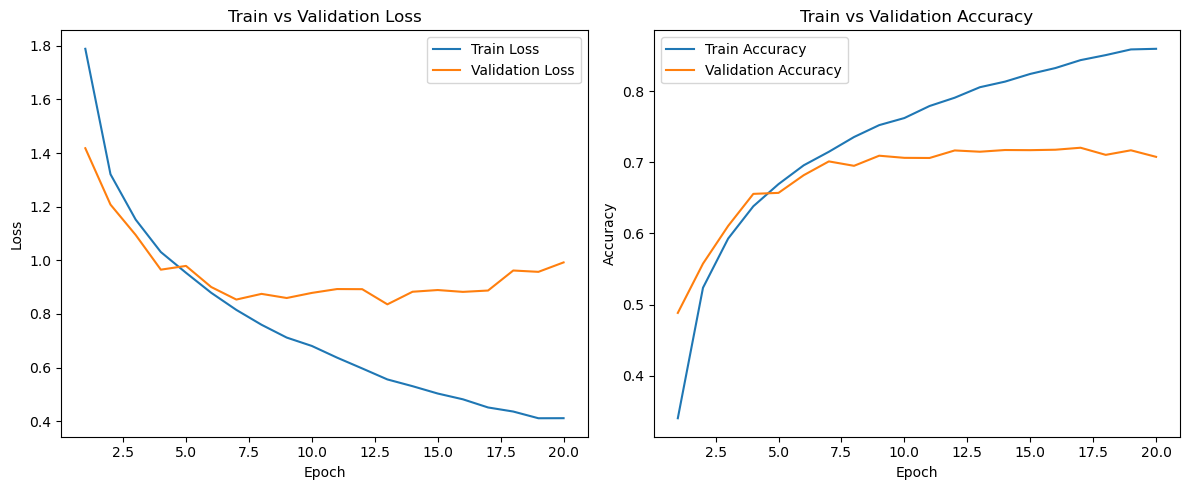

Testing on the testset


C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\2856374297.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_sav

Test Accuracy: 0.72

Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1000
           1       0.84      0.85      0.85      1000
           2       0.59      0.65      0.62      1000
           3       0.52      0.60      0.56      1000
           4       0.65      0.70      0.68      1000
           5       0.66      0.61      0.64      1000
           6       0.74      0.77      0.76      1000
           7       0.81      0.70      0.75      1000
           8       0.82      0.81      0.82      1000
           9       0.84      0.75      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000


Weight Decay: 0.001
Model Training


100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 1, Train Loss: 1.8364, Train Accuracy: 0.31, Validation Loss: 1.5371, Validation Accuracy: 0.42
Model saved with Validation Accuracy: 0.42


100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


Epoch 2, Train Loss: 1.3941, Train Accuracy: 0.49, Validation Loss: 1.1772, Validation Accuracy: 0.58
Model saved with Validation Accuracy: 0.58


100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


Epoch 3, Train Loss: 1.2013, Train Accuracy: 0.58, Validation Loss: 1.0974, Validation Accuracy: 0.61
Model saved with Validation Accuracy: 0.61


100%|██████████| 40/40 [00:14<00:00,  2.81it/s]


Epoch 4, Train Loss: 1.0958, Train Accuracy: 0.62, Validation Loss: 1.0185, Validation Accuracy: 0.64
Model saved with Validation Accuracy: 0.64


100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Epoch 5, Train Loss: 1.0047, Train Accuracy: 0.65, Validation Loss: 0.9611, Validation Accuracy: 0.66
Model saved with Validation Accuracy: 0.66


100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


Epoch 6, Train Loss: 0.9551, Train Accuracy: 0.67, Validation Loss: 0.9315, Validation Accuracy: 0.67
Model saved with Validation Accuracy: 0.67


100%|██████████| 40/40 [00:13<00:00,  2.89it/s]


Epoch 7, Train Loss: 0.9149, Train Accuracy: 0.68, Validation Loss: 0.9113, Validation Accuracy: 0.68
Model saved with Validation Accuracy: 0.68


100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


Epoch 8, Train Loss: 0.8719, Train Accuracy: 0.70, Validation Loss: 0.9299, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Epoch 9, Train Loss: 0.8274, Train Accuracy: 0.71, Validation Loss: 0.8584, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Epoch 10, Train Loss: 0.8100, Train Accuracy: 0.72, Validation Loss: 0.8707, Validation Accuracy: 0.70
Model saved with Validation Accuracy: 0.70


100%|██████████| 40/40 [00:13<00:00,  2.88it/s]


Epoch 11, Train Loss: 0.7882, Train Accuracy: 0.73, Validation Loss: 0.8666, Validation Accuracy: 0.70


100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Epoch 12, Train Loss: 0.7554, Train Accuracy: 0.74, Validation Loss: 0.8756, Validation Accuracy: 0.71
Model saved with Validation Accuracy: 0.71


100%|██████████| 40/40 [00:13<00:00,  2.99it/s]


Epoch 13, Train Loss: 0.7312, Train Accuracy: 0.75, Validation Loss: 0.8246, Validation Accuracy: 0.71
Model saved with Validation Accuracy: 0.71


100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


Epoch 14, Train Loss: 0.7156, Train Accuracy: 0.75, Validation Loss: 0.8269, Validation Accuracy: 0.71
Model saved with Validation Accuracy: 0.71


100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


Epoch 15, Train Loss: 0.6965, Train Accuracy: 0.76, Validation Loss: 0.7674, Validation Accuracy: 0.74
Model saved with Validation Accuracy: 0.74


100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


Epoch 16, Train Loss: 0.6772, Train Accuracy: 0.77, Validation Loss: 0.8452, Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Epoch 17, Train Loss: 0.6647, Train Accuracy: 0.77, Validation Loss: 0.8952, Validation Accuracy: 0.71


100%|██████████| 40/40 [00:13<00:00,  2.93it/s]


Epoch 18, Train Loss: 0.6527, Train Accuracy: 0.78, Validation Loss: 0.8494, Validation Accuracy: 0.72


100%|██████████| 40/40 [00:13<00:00,  2.90it/s]


Epoch 19, Train Loss: 0.6331, Train Accuracy: 0.78, Validation Loss: 0.8132, Validation Accuracy: 0.73


100%|██████████| 40/40 [00:14<00:00,  2.85it/s]


Epoch 20, Train Loss: 0.6179, Train Accuracy: 0.79, Validation Loss: 0.8488, Validation Accuracy: 0.72


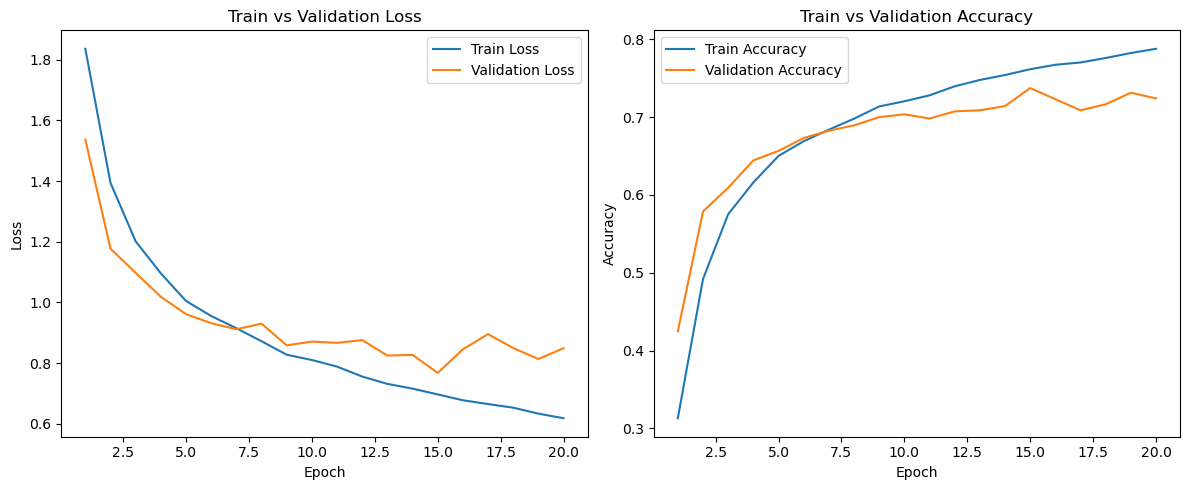

C:\Users\abrar\AppData\Local\Temp\ipykernel_36248\2856374297.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_sav

Testing on the testset


100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Test Accuracy: 0.73

Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1000
           1       0.85      0.86      0.85      1000
           2       0.65      0.61      0.63      1000
           3       0.50      0.62      0.55      1000
           4       0.71      0.65      0.68      1000
           5       0.74      0.52      0.61      1000
           6       0.76      0.81      0.78      1000
           7       0.77      0.79      0.78      1000
           8       0.80      0.84      0.82      1000
           9       0.80      0.83      0.82      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000




In [ ]:
# weight decay value test with Adam

# Selected learning rate = 0.001
# From the above result we can see overfitting
# Here I am using L2 regularization (weight decay) to minimize overfitting 

learning_rate = 0.001
weight_decay = [1e-4, 1e-3]

for wd in weight_decay:
    model_alexnet = AlexNet(num_classes=num_class)
    model_alexnet.to(device)

    print(f'Weight Decay: {wd}')
    
    optimizer = optim.Adam(model_alexnet.parameters(), lr=learning_rate, weight_decay=wd)
    alexnet_weight_save_path = Path(f'./save_model/best_model_AlexNet_Adam_lr_{learning_rate}_wd_{wd}.pth')

    # Training model
    print("Model Training")
    model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

    # Load the best saved model weights for evaluation
    print("Testing on the testset")
    model_alexnet.load_state_dict(torch.load(alexnet_weight_save_path))
    
    # Evaluate model on test data
    test_step(model_alexnet, test_dataloader)
    
    torch.cuda.empty_cache()
    print()
    print("==============================================================================================================")
    time.sleep(30)

Weight Decay: 0.0001
Model Training


100%|██████████| 40/40 [00:04<00:00,  8.25it/s]


Epoch 1, Train Loss: 1.6490, Train Accuracy: 0.39, Validation Loss: 1.3507, Validation Accuracy: 0.51
Model saved with Validation Accuracy: 0.51


100%|██████████| 40/40 [00:04<00:00,  8.30it/s]


Epoch 2, Train Loss: 1.1824, Train Accuracy: 0.57, Validation Loss: 0.9886, Validation Accuracy: 0.65
Model saved with Validation Accuracy: 0.65


100%|██████████| 40/40 [00:04<00:00,  8.21it/s]


Epoch 3, Train Loss: 0.9330, Train Accuracy: 0.67, Validation Loss: 0.8268, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


Epoch 4, Train Loss: 0.7567, Train Accuracy: 0.74, Validation Loss: 0.7847, Validation Accuracy: 0.72
Model saved with Validation Accuracy: 0.72


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


Epoch 5, Train Loss: 0.6281, Train Accuracy: 0.78, Validation Loss: 0.6347, Validation Accuracy: 0.78
Model saved with Validation Accuracy: 0.78


100%|██████████| 40/40 [00:04<00:00,  8.20it/s]


Epoch 6, Train Loss: 0.5252, Train Accuracy: 0.82, Validation Loss: 0.6187, Validation Accuracy: 0.79
Model saved with Validation Accuracy: 0.79


100%|██████████| 40/40 [00:04<00:00,  8.24it/s]


Epoch 7, Train Loss: 0.4291, Train Accuracy: 0.85, Validation Loss: 0.5971, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 8, Train Loss: 0.3368, Train Accuracy: 0.88, Validation Loss: 0.6105, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.43it/s]


Epoch 9, Train Loss: 0.2702, Train Accuracy: 0.91, Validation Loss: 0.5906, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


Epoch 10, Train Loss: 0.2037, Train Accuracy: 0.93, Validation Loss: 0.6379, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


Epoch 11, Train Loss: 0.1555, Train Accuracy: 0.95, Validation Loss: 0.6669, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Epoch 12, Train Loss: 0.1155, Train Accuracy: 0.96, Validation Loss: 0.7657, Validation Accuracy: 0.80


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 13, Train Loss: 0.0995, Train Accuracy: 0.97, Validation Loss: 0.6698, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.29it/s]


Epoch 14, Train Loss: 0.0816, Train Accuracy: 0.97, Validation Loss: 0.8306, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.39it/s]


Epoch 15, Train Loss: 0.0706, Train Accuracy: 0.98, Validation Loss: 0.8266, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 16, Train Loss: 0.0704, Train Accuracy: 0.98, Validation Loss: 0.8368, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.33it/s]


Epoch 17, Train Loss: 0.0611, Train Accuracy: 0.98, Validation Loss: 0.8322, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 18, Train Loss: 0.0578, Train Accuracy: 0.98, Validation Loss: 0.8661, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Epoch 19, Train Loss: 0.0514, Train Accuracy: 0.98, Validation Loss: 0.8858, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


Epoch 20, Train Loss: 0.0492, Train Accuracy: 0.98, Validation Loss: 0.9085, Validation Accuracy: 0.82


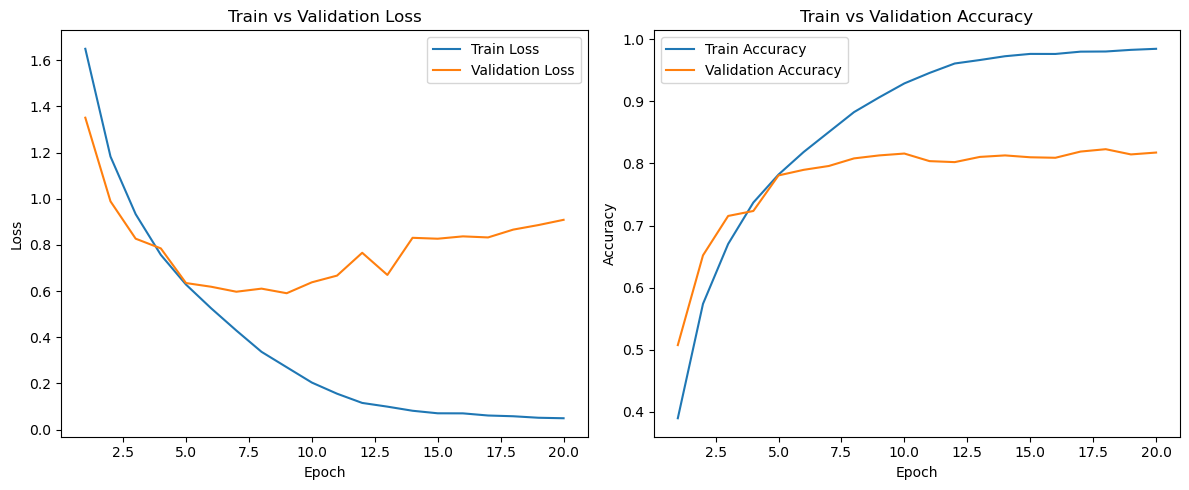

C:\Users\abrar\AppData\Local\Temp\ipykernel_15684\1697246296.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_sav

Testing on the testset


100%|██████████| 79/79 [00:09<00:00,  7.93it/s]


Test Accuracy: 0.81

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1000
           1       0.86      0.93      0.89      1000
           2       0.72      0.76      0.74      1000
           3       0.76      0.51      0.61      1000
           4       0.82      0.76      0.79      1000
           5       0.69      0.80      0.74      1000
           6       0.86      0.88      0.87      1000
           7       0.83      0.88      0.85      1000
           8       0.90      0.88      0.89      1000
           9       0.84      0.88      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000


Weight Decay: 0.001
Model Training


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


Epoch 1, Train Loss: 1.6668, Train Accuracy: 0.38, Validation Loss: 1.3115, Validation Accuracy: 0.52
Model saved with Validation Accuracy: 0.52


100%|██████████| 40/40 [00:04<00:00,  8.20it/s]


Epoch 2, Train Loss: 1.2031, Train Accuracy: 0.57, Validation Loss: 1.0563, Validation Accuracy: 0.63
Model saved with Validation Accuracy: 0.63


100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch 3, Train Loss: 0.9485, Train Accuracy: 0.66, Validation Loss: 0.8793, Validation Accuracy: 0.69
Model saved with Validation Accuracy: 0.69


100%|██████████| 40/40 [00:04<00:00,  8.49it/s]


Epoch 4, Train Loss: 0.7996, Train Accuracy: 0.72, Validation Loss: 0.7593, Validation Accuracy: 0.74
Model saved with Validation Accuracy: 0.74


100%|██████████| 40/40 [00:04<00:00,  8.09it/s]


Epoch 5, Train Loss: 0.6916, Train Accuracy: 0.76, Validation Loss: 0.7291, Validation Accuracy: 0.74
Model saved with Validation Accuracy: 0.74


100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


Epoch 6, Train Loss: 0.6101, Train Accuracy: 0.79, Validation Loss: 0.6304, Validation Accuracy: 0.78
Model saved with Validation Accuracy: 0.78


100%|██████████| 40/40 [00:04<00:00,  8.15it/s]


Epoch 7, Train Loss: 0.5363, Train Accuracy: 0.81, Validation Loss: 0.6403, Validation Accuracy: 0.79
Model saved with Validation Accuracy: 0.79


100%|██████████| 40/40 [00:04<00:00,  8.06it/s]


Epoch 8, Train Loss: 0.4640, Train Accuracy: 0.84, Validation Loss: 0.6033, Validation Accuracy: 0.79
Model saved with Validation Accuracy: 0.79


100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


Epoch 9, Train Loss: 0.4054, Train Accuracy: 0.86, Validation Loss: 0.6116, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Epoch 10, Train Loss: 0.3466, Train Accuracy: 0.88, Validation Loss: 0.5990, Validation Accuracy: 0.80
Model saved with Validation Accuracy: 0.80


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


Epoch 11, Train Loss: 0.2941, Train Accuracy: 0.90, Validation Loss: 0.6083, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.32it/s]


Epoch 12, Train Loss: 0.2410, Train Accuracy: 0.92, Validation Loss: 0.6878, Validation Accuracy: 0.81
Model saved with Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.40it/s]


Epoch 13, Train Loss: 0.2060, Train Accuracy: 0.93, Validation Loss: 0.5986, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.08it/s]


Epoch 14, Train Loss: 0.1693, Train Accuracy: 0.94, Validation Loss: 0.6427, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.31it/s]


Epoch 15, Train Loss: 0.1500, Train Accuracy: 0.95, Validation Loss: 0.7064, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:05<00:00,  7.83it/s]


Epoch 16, Train Loss: 0.1276, Train Accuracy: 0.96, Validation Loss: 0.7216, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.11it/s]


Epoch 17, Train Loss: 0.1214, Train Accuracy: 0.96, Validation Loss: 0.7073, Validation Accuracy: 0.81


100%|██████████| 40/40 [00:04<00:00,  8.13it/s]


Epoch 18, Train Loss: 0.1103, Train Accuracy: 0.96, Validation Loss: 0.7083, Validation Accuracy: 0.82
Model saved with Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.22it/s]


Epoch 19, Train Loss: 0.0944, Train Accuracy: 0.97, Validation Loss: 0.6625, Validation Accuracy: 0.82


100%|██████████| 40/40 [00:04<00:00,  8.23it/s]


Epoch 20, Train Loss: 0.0929, Train Accuracy: 0.97, Validation Loss: 0.7278, Validation Accuracy: 0.82


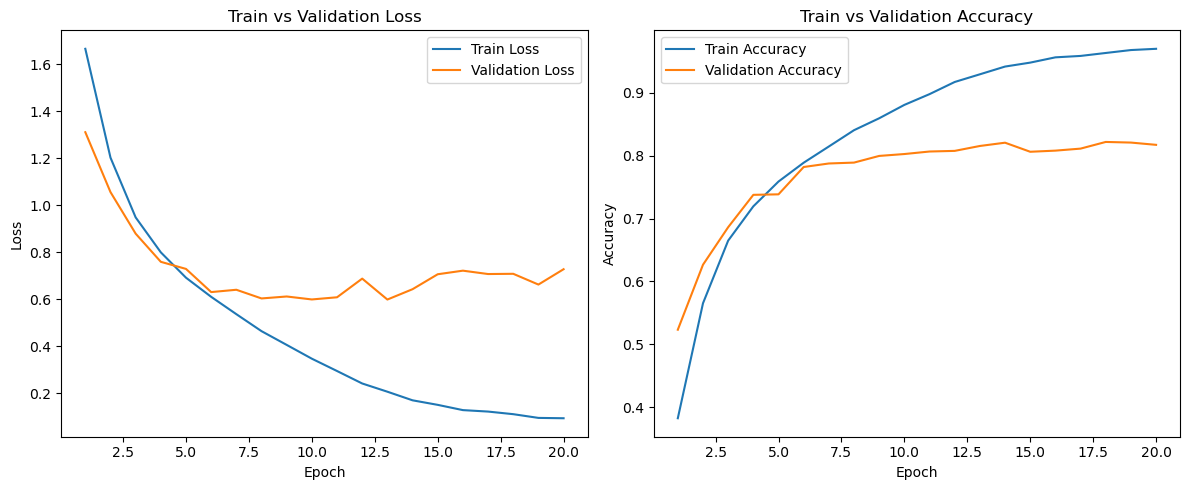

C:\Users\abrar\AppData\Local\Temp\ipykernel_15684\1697246296.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_alexnet.load_state_dict(torch.load(alexnet_weight_sav

Testing on the testset


100%|██████████| 79/79 [00:10<00:00,  7.69it/s]


Test Accuracy: 0.82

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.94      0.87      0.90      1000
           2       0.75      0.77      0.76      1000
           3       0.61      0.76      0.68      1000
           4       0.81      0.78      0.80      1000
           5       0.78      0.70      0.74      1000
           6       0.87      0.87      0.87      1000
           7       0.87      0.85      0.86      1000
           8       0.91      0.88      0.90      1000
           9       0.88      0.89      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000




In [36]:
learning_rate = 0.0001
weight_decay = [1e-4, 1e-3]

for wd in weight_decay:
    model_alexnet = AlexNet(num_classes=num_class)
    model_alexnet.to(device)

    print(f'Weight Decay: {wd}')
    
    optimizer = optim.Adam(model_alexnet.parameters(), lr=learning_rate, weight_decay=wd)
    alexnet_weight_save_path = Path(f'./save_model/best_model_AlexNet_Adam_lr_{learning_rate}_wd_{wd}.pth')

    # Training model
    print("Model Training")
    model_training(model_alexnet, train_dataloader, val_dataloader, num_epoch, alexnet_weight_save_path, optimizer)

    # Load the best saved model weights for evaluation
    print("Testing on the testset")
    model_alexnet.load_state_dict(torch.load(alexnet_weight_save_path))
    
    # Evaluate model on test data
    test_step(model_alexnet, test_dataloader)
    
    torch.cuda.empty_cache()
    print()
    print("==============================================================================================================")
    time.sleep(30)